## Gaussian Localization -- Condensed

In [376]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


In [634]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

### Forward model parameters
Filter mask, PSF

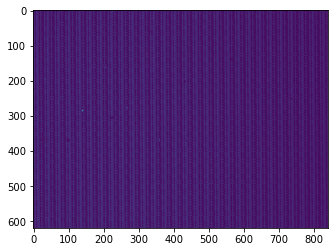

Shape of the filter array: torch.Size([620, 840, 45])


In [572]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


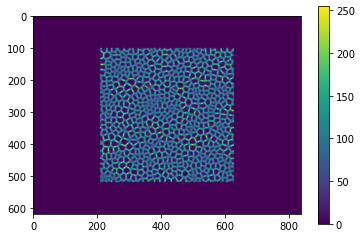

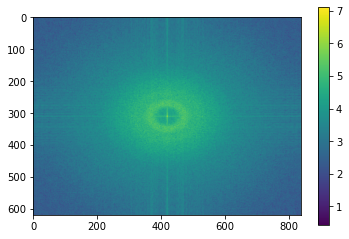

In [573]:
# PSF

datafolder = '../PSF'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

### Construct ground truth gaussian object

In [627]:
# Ground truth parameters -- must be floats
muy = 50.0
mux = 50.0
mul = 10.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

In [635]:
# Create gaussian object and 3D array
g_ground = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d = g_ground.createPixelGauss(NY,NX,NL)

### Get ground truth measurement

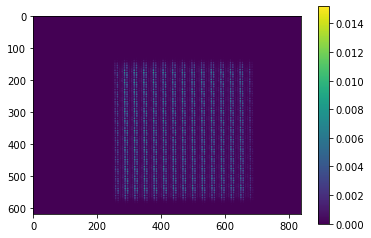

In [636]:
# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_padded = sdc.pad(g3d.detach())

# Get measurement
gt_measurement = sdc.forwardmodel3d(g3d_padded, hf_padded_3d, m)
gt_measurement = gt_measurement/torch.norm(gt_measurement) # normalize
plt.figure()
plt.imshow(gt_measurement.detach().numpy())
plt.colorbar()
plt.show() 

### Initialize random gaussian guess

In [637]:
# Define a Gaussian object with initialized values

# Initialized guess parameters -- must be floats
muy_init = 0.
mux_init = 0.
mul_init = 0.
sigy_init = 10.
sigx_init = 10.
sigl_init = 1.
lr_init = 15
NY, NX, NL = m.shape

g_init = gp.GaussObject(muy_init,mux_init,mul_init,sigy_init,sigx_init,sigl_init,learningrate=lr_init)

gaussObject(mu_x = 0.0, mu_y = 0.0, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
tensor(0., requires_grad=True)
tensor(0., requires_grad=True)


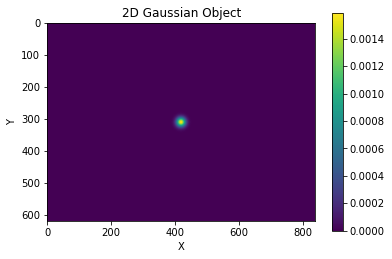

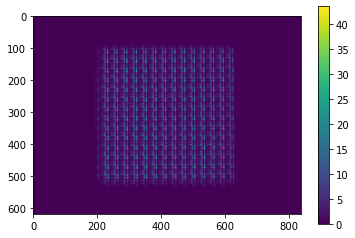

In [638]:
# Display the initial Gaussian guess and its measurement

# Object
print(g_init)
g_init.plot(coords,NY,NX)

# Measurement
g_init_meas = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
plt.figure()
plt.imshow(g_init_meas.detach().numpy())
plt.colorbar()
plt.show() 

### Gradient descent

tensor(0., requires_grad=True)
tensor(0., requires_grad=True)


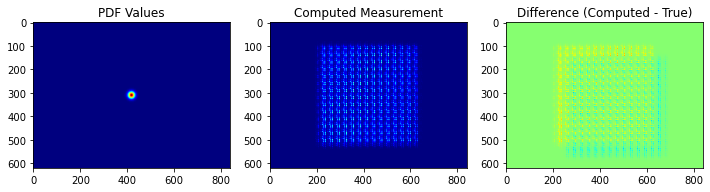

Gradient mux:  tensor(-0.0005)
Gradient muy:  tensor(-0.0008)
Gradient mul:  None
tensor(14.9997, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(-0.0008)
Gradient muy:  tensor(-0.0007)
Gradient mul:  None
tensor(29.8493, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(-0.0005)
Gradient muy:  tensor(-0.0008)
Gradient mul:  None
tensor(44.4036, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(-0.0002)
Gradient muy:  tensor(-0.0002)
Gradient mul:  None
tensor(57.7340, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0004)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(65.3002, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0005)
Gradient muy:  tensor(0.0006)
Gradient mul:  None
tensor(68.0419, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0005)
Gradient muy:  tensor(0.0008)
Gradient mul:  None
tensor(67.4268, requires_grad=

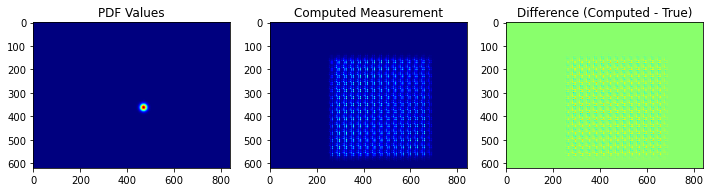

Gradient mux:  tensor(0.0001)
Gradient muy:  tensor(8.5486e-05)
Gradient mul:  None
tensor(54.7945, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0003)
Gradient muy:  tensor(0.0001)
Gradient mul:  None
tensor(56.3678, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0004)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(56.2470, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0003)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(54.6598, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0003)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(52.0780, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(0.0001)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(49.1601, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(-2.0072e-05)
Gradient muy:  tensor(0.0002)
Gradient mul:  None
tensor(46.5888, requires_grad

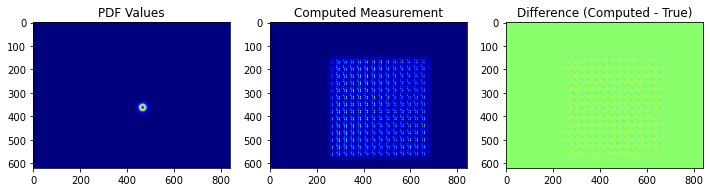

Gradient mux:  tensor(-7.7240e-05)
Gradient muy:  tensor(9.8897e-05)
Gradient mul:  None
tensor(46.9857, requires_grad=True)
tensor(0., requires_grad=True)
Gradient mux:  tensor(-0.0001)
Gradient muy:  tensor(0.0001)
Gradient mul:  None


KeyboardInterrupt: 

In [639]:
# Set number of iterations and initialize the loss tracker
# Need to rerun initialize random gaussian guess cells every time **
max_iters = 200
thresh = 1e-10
loss_GD = []
params_GD = {'mux':[],'muy':[], 'mul':[], 'sigx':[], 'sigy':[], 'sigl':[]}

# Optimization loop
for i in range(max_iters):
    # Compute forward model using the current Gaussian parameters
    computed_measurement = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
    computed_measurement = computed_measurement / torch.norm(computed_measurement) # normalize
    
    # Compute PDF values based on the Gaussian parameters
    computed_values = g_init.computeValues(coords, NY, NX)
    
    # Plot the results every 10 iterations (optional)
    if i % 20 == 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(computed_values.detach().cpu().numpy(), cmap='jet')
        plt.title("PDF Values")

        plt.subplot(1, 3, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Computed Measurement")

        plt.subplot(1, 3, 3)
        plt.imshow((computed_measurement - gt_measurement).detach().cpu().numpy(), cmap='jet')
        plt.title("Difference (Computed - True)")
        
        plt.show()
    
    # Store the loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - gt_measurement)
    loss_GD.append(loss.item())
    if i > 0: # stop if loss isn't changing
        if np.abs(loss_GD[i] - loss_GD[i-1]) < thresh:
            break
    
    # Store the guess parameters
    params_GD['mux'].append(float(g_init.mux.detach().numpy()))
    params_GD['muy'].append(float(g_init.muy.detach().numpy()))
    params_GD['mul'].append(float(g_init.mul.detach().numpy()))
    params_GD['sigx'].append(float(g_init.sigx.detach().numpy()))
    params_GD['sigy'].append(float(g_init.sigy.detach().numpy()))
    params_GD['sigl'].append(float(g_init.sigl.detach().numpy()))
    
    # Perform a gradient step to update Gaussian parameters
    loss.backward()
    print("Gradient mux: ", g_init.mux.grad)
    print("Gradient muy: ", g_init.muy.grad)
    print("Gradient mul: ", g_init.mul.grad)
    g_init.gradStep()
    
    # Zero the gradients after the update
    g_init.zeroGrad()

# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()

# Plot the change in learned parameters over iterations
plt.figure()
plt.plot(params_GD['mux'], label='mux')
plt.plot(params_GD['muy'], label='muy')
plt.plot(params_GD['mul'], label='mul')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Parameters')
plt.title('Parameters Learned during Gradient Descent')
plt.show()

## PSF comparisons

In [502]:
[f for f in os.listdir(datafolder) if '090' in f]

['psf_090_1.png', 'psf_090_3.png', 'psf_090_2.png', 'psf_090_4.png']

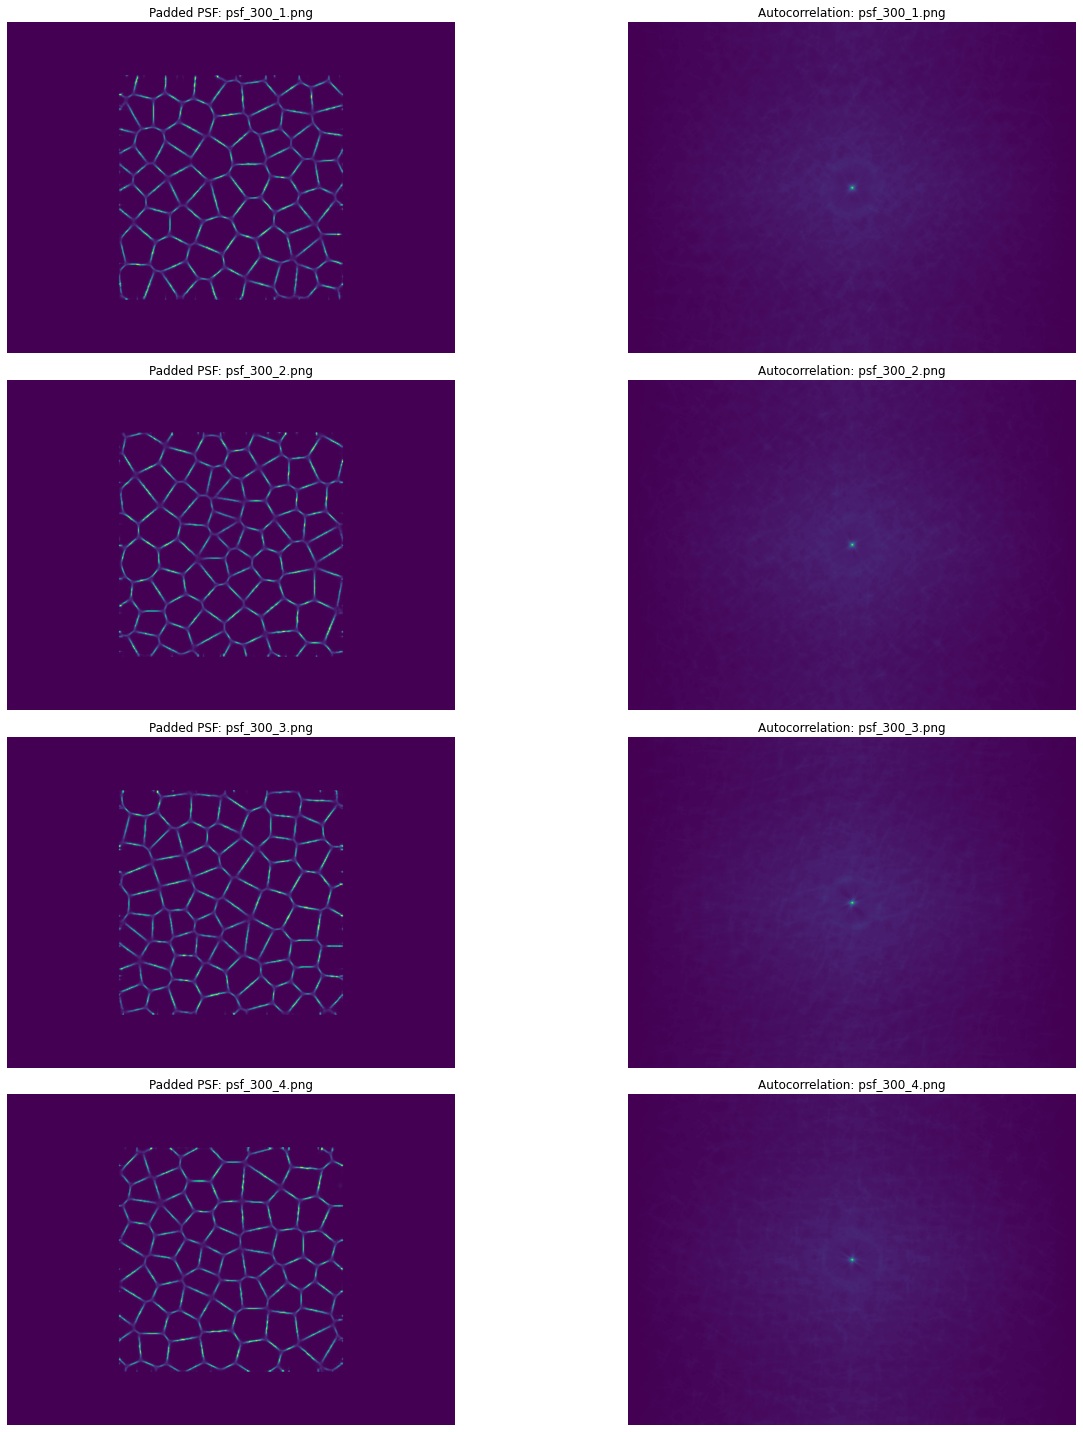

In [510]:
# PSF directory
datafolder = '../PSF/'

psf_files_090 = sorted([f for f in os.listdir(datafolder) if '090' in f])
psf_files_150 = sorted([f for f in os.listdir(datafolder) if '150' in f])
psf_files_300 = sorted([f for f in os.listdir(datafolder) if '300' in f])

# Create the figure
cols = 2
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows))
axes = axes.flatten()  # Flatten to access subplots in a single loop

# Iterate over each file
for i, fname in enumerate(psf_files_300):
    # Load the PSF image
    psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

    # Expand the PSF to match the shape of the filter array
    pad_h = (m.shape[0] - psf.shape[0]) // 2
    pad_w = (m.shape[1] - psf.shape[1]) // 2
    padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
    h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)

    # Plot the padded PSF (h)
    ax_psf = axes[2 * i]
    ax_psf.imshow(h)
    ax_psf.set_title(f"Padded PSF: {fname}")
    ax_psf.axis('off')

    # Compute autocorrelation
    hf = torch.fft.fftshift(torch.fft.fft2(h))
    h_autocorr = torch.fft.fftshift(torch.fft.ifft2(np.abs(hf) ** 2))

    # Plot autocorrelation
    ax_ac = axes[2 * i + 1]
    ax_ac.imshow(np.abs(h_autocorr.detach().numpy()))
    ax_ac.set_title(f"Autocorrelation: {fname}")
    ax_ac.axis('off')

plt.tight_layout()
plt.show()


## Debugging

All debugging code can go below

### Compare sdc vs. gaussplat measurements
Generally useful to plot as we make updates to the forward models

In [550]:
# Gaussian parameters -- must be floats
muy = 50.2
mux = 150.
mul = 0.
sigy = 10.
sigx = 10.
sigl = 1.
NY, NX, NL = m.shape

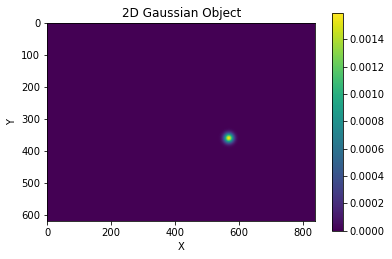

In [551]:
# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d_test = g_test.createPixelGauss(NY,NX,NL)
g_test.plot(coords, NY, NX)

In [552]:
# Pixel forward model

# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_test_padded = sdc.pad(g3d_test.detach())

# Get measurement
g3_test_measurement = sdc.forwardmodel3d(g3d_test_padded, hf_padded_3d, m)
g3_test_measurement = g3_test_measurement/torch.norm(g3_test_measurement) # normalize

In [553]:
# Gaussian forward model

# Get measurement
g_test_measurement = gp.forwardSingleGauss(g_test, NX, NY, NL, h, m)
g_test_measurement = g_test_measurement/torch.norm(g_test_measurement)

In [554]:
# Get difference
g_test_diff = g3_test_measurement - g_test_measurement
mse = torch.norm(g_test_diff)

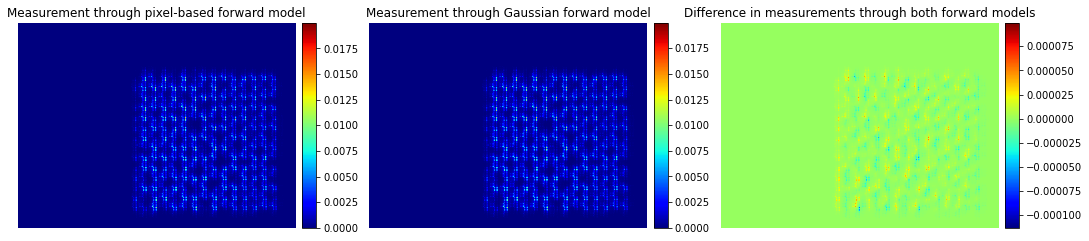

MSE:  0.0035664952376068247


In [555]:
# Plot difference and get MSE

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust `figsize` as needed for better visuals

im1 = axes[0].imshow(g3_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g3_test_measurement.min().item(), 
                     vmax=g3_test_measurement.max().item())
axes[0].set_title("Measurement through pixel-based forward model")
axes[0].axis('off')
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)  # Adjust size and pad for appearance
fig.colorbar(im1, cax=cax1)

im2 = axes[1].imshow(g_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g_test_measurement.min().item(), 
                     vmax=g_test_measurement.max().item())
axes[1].set_title("Measurement through Gaussian forward model")
axes[1].axis('off')
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im2, cax=cax2)

im3 = axes[2].imshow(g_test_diff.detach().numpy(), cmap='jet', 
                     vmin=g_test_diff.min().item(), 
                     vmax=g_test_diff.max().item())
axes[2].set_title("Difference in measurements through both forward models")
axes[2].axis('off')
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im3, cax=cax3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print("MSE: ", mse.detach().numpy())

### Wavelength

In [267]:
# 3D Gaussian
muy = 50.2
mux = 150.2
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3_test = g_test.createPixelGauss(NY,NX,NL)

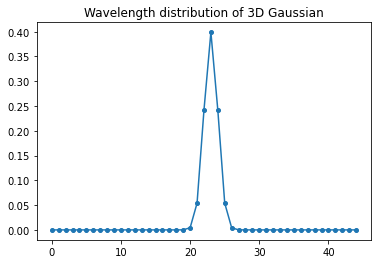

ValueError: too many values to unpack (expected 2)

In [268]:
# Plot wavelength distributions

# 3D Gaussian
g3_wavelength_proj = g3d.sum(dim=(0,1)).detach()
plt.plot(g3_wavelength_proj, marker='o', markersize=4)
plt.title("Wavelength distribution of 3D Gaussian")
plt.show()

# Wavelength filter
_, gaus_lam = gp.createWVFilt(mul, sigl, NL, m)
plt.plot(gaus_lam, marker='o', markersize=4)
plt.title("Wavelength distribution of weighting applied to filter array")
plt.show()

### Check phasor

In [426]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

In [431]:
# 3D Gaussian
muy = 8.2
mux = 0.
mul = 0.
sigy = 10.
sigx = 10.
sigl = 1.
NY, NX, NL = m.shape

# Create gaussian object and 2D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g_test_vals = g_test.computeValues(coords, NY, NX)

# Create phasor and phase ramp of gaussian object
phasor_test, phaseramp_test = gp.createPhasor(x+1.1,y,g_test.mux,g_test.muy)

# Compute phasor using pixelated array
g_test_vals_f = torch.fft.fftshift(torch.fft.fft2(g_test_vals))
g_test_vals_phasor = torch.angle(g_test_vals_f).detach().numpy()

In [432]:
phaseramp_test.shape

torch.Size([620, 840])

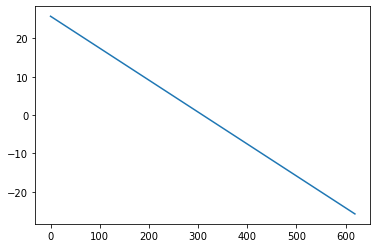

In [433]:
plt.plot(phaseramp_test[:,1].detach().numpy())

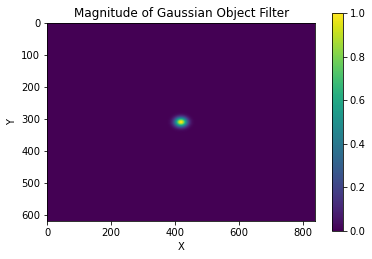

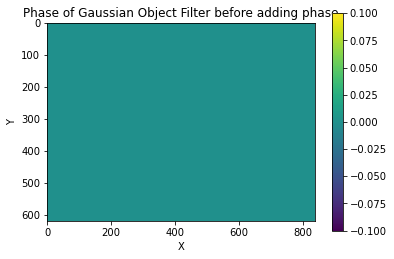

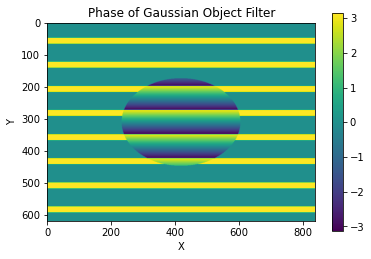

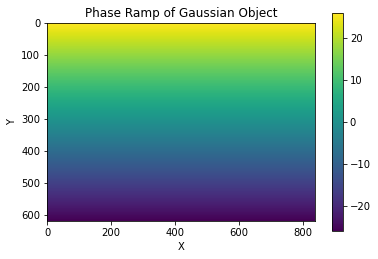

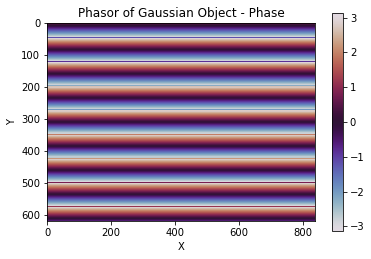

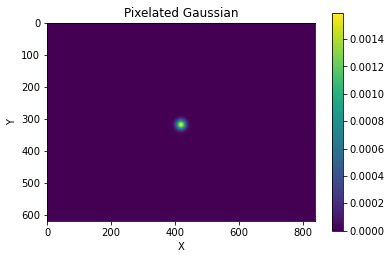

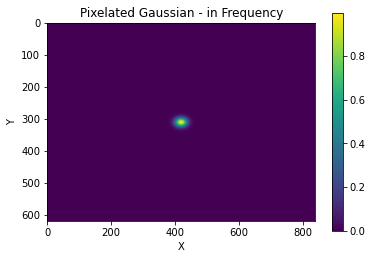

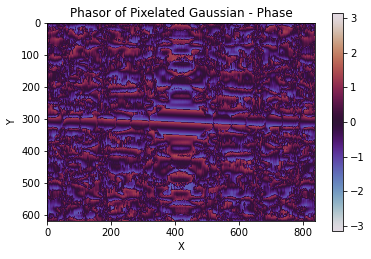

In [434]:
gauss_f_values_test = gp.createGaussFilter(g_test.covariancematrix, coords, NX, NY, g_test.amplitude)
gauss_f_test = gauss_f_values_test * phasor_test

plt.figure()
plt.imshow(np.abs(gauss_f_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Magnitude of Gaussian Object Filter')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(gauss_f_values_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase of Gaussian Object Filter before adding phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(gauss_f_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase of Gaussian Object Filter')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(phaseramp_test.detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase Ramp of Gaussian Object')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(phasor_test.detach().numpy()), cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Gaussian Object - Phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(g_test_vals.detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pixelated Gaussian')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.abs(g_test_vals_f.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pixelated Gaussian - in Frequency')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(g_test_vals_phasor, cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Pixelated Gaussian - Phase')
plt.colorbar()
plt.show()

In [277]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

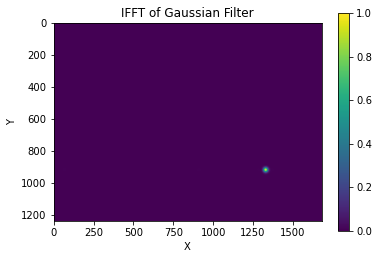

In [280]:
gauss_f_test_ifft = torch.fft.fftshift(torch.fft.ifft2(gauss_f_test,dim=(0,1)))
gauss_f_test_ifft = gauss_f_test_ifft/torch.amax(torch.abs(gauss_f_test_ifft))

plt.figure()
plt.imshow(torch.abs(gauss_f_test_ifft.detach()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('IFFT of Gaussian Filter')
plt.colorbar()
plt.show()